###### now that I have gotten some decent results using 50 epochs, I want the best model so I will use the patience in callback that we used before to get that and compare that model to the 50 epoch one.

# The model that works : CNN autoencoder

In [1]:
## Importing important stuff
import random
import numpy as np
import pandas as pd
from PIL import Image 
import tifffile as tiff
             ###############
#plotting
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
            ####################
#machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical   
###
from keras import models
from keras import layers

#from __future__ import print_function
#import keras
from keras import backend as K
#import matplotlib
#from matplotlib import pyplot as plt
#import numpy as np
from keras.preprocessing.image import ImageDataGenerator
###
import pickle as pkl
import time

Using TensorFlow backend.


In [2]:
gd_train=np.load('gd_train_28.npy')
gd_test= np.load('gd_test_28.npy')
bd_train= np.load('bd_train_28.npy')
bd_test= np.load('bd_test_28.npy')


In [3]:
print('length of gd_train ' + str(len(gd_train)))
print('length of gd_test ' + str(len(gd_test)))
print('length of bd_train ' + str(len(bd_train)))
print('length of bd_test ' + str(len(bd_test)))

length of gd_train 345920
length of gd_test 57960
length of bd_train 345920
length of bd_test 57960


In [4]:
#importing the network since it was saved before 

In [8]:
### adding patience to call back


#creating the network
#trying CNN autoencoder

from keras import models
from keras import layers
from keras import regularizers

# make our encoder
encoder = models.Sequential()
#
# First convolutional layer
encoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',input_shape=(28,28,1)))
encoder.add(layers.MaxPooling2D((2,2), padding='same'))
encoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
encoder.add(layers.MaxPooling2D((2,2), padding='same'))
encoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
encoder.add(layers.MaxPooling2D((2,2), padding='same'))
print("encoder===>")
print(encoder.summary())

#
# Now make the decoder
# make our encoder
decoder = models.Sequential()
#
# First convolutional layer
decoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same',input_shape=(4,4,8)))
decoder.add(layers.UpSampling2D((2,2)))
decoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
decoder.add(layers.UpSampling2D((2,2)))
decoder.add(layers.Conv2D(16, (3, 3), activation='relu'))
decoder.add(layers.UpSampling2D((2,2)))
decoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
print("decoder===>")
print(decoder.summary())

#

autoencoder = models.Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)
#
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])
#autoencoder.compile(optimizer='adadelta', loss='mse',metrics=['mse'])
print("autoencoder===>")
print(autoencoder.summary())

encoder===>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
______________________________________________________________

In [4]:
##### adjusting the shape of the data
bd_train = bd_train.reshape((bd_train.shape[0],28,28,1))
gd_train = gd_train.reshape((gd_train.shape[0],28,28,1))
bd_test = bd_test.reshape((bd_test.shape[0],28,28,1))
gd_test = gd_test.reshape((gd_test.shape[0],28,28,1))

In [9]:
#####
#Here I try monitoring the mse and minimizing that 

from keras.callbacks import EarlyStopping, ModelCheckpoint

autoencoder.save_weights('model_init.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_mean_squared_error', save_best_only=True)]

autoencoder.load_weights('model_init.h5')
history = autoencoder.fit(bd_train,gd_train,
                              epochs=100,
                              batch_size=128,
                              verbose=1, # set to 0 for no printout while running
                              callbacks=callbacks, # Early stopping
                              validation_data=(bd_test,gd_test))

Train on 345920 samples, validate on 57960 samples
Epoch 1/100
345920/345920 [==============================] - 108s 313us/step - loss: 0.6623 - mean_squared_error: 0.0223 - val_loss: 0.4742 - val_mean_squared_error: 0.0462
Epoch 2/100
345920/345920 [==============================] - 107s 308us/step - loss: 0.5907 - mean_squared_error: 0.0149 - val_loss: 0.4466 - val_mean_squared_error: 0.0426
Epoch 3/100
345920/345920 [==============================] - 107s 309us/step - loss: 0.5802 - mean_squared_error: 0.0138 - val_loss: 0.4398 - val_mean_squared_error: 0.0416
Epoch 4/100
345920/345920 [==============================] - 106s 307us/step - loss: 0.5759 - mean_squared_error: 0.0134 - val_loss: 0.3851 - val_mean_squared_error: 0.0389
Epoch 5/100
345920/345920 [==============================] - 106s 307us/step - loss: 0.5735 - mean_squared_error: 0.0132 - val_loss: 0.3740 - val_mean_squared_error: 0.0384
Epoch 6/100
345920/345920 [==============================] - 107s 309us/step - loss:

# stopped at 32 means the best model was at 22 epoochs

In [10]:
# rms histogram 

#### output of history :: {'val_loss': [list of values as long sa the number of epochs], 
##                         'val_mean_squared_error': , 
##                         ' loss':, 
##                      'mean_squared_error'}




### plot the mean _ squared_ error with respect to epoch for both test and val



### make the intensity over a certain line plot

In [11]:
## in order to get mean_squared_error 


In [10]:
import pickle
with open("patience_mse_train.txt", "wb") as f:   #Pickling
    pickle.dump(history.history['mean_squared_error'], f)
with open("patience_mse_test.txt", "wb") as f:   #Pickling
    pickle.dump(history.history['val_mean_squared_error'], f)
with open("patience_loss_train.txt", "wb") as f:   #Pickling
    pickle.dump(history.history['loss'], f)
with open("patience_loss_test.txt", "wb") as f:   #Pickling
    pickle.dump(history.history['val_loss'], f)

## Perfomance plots

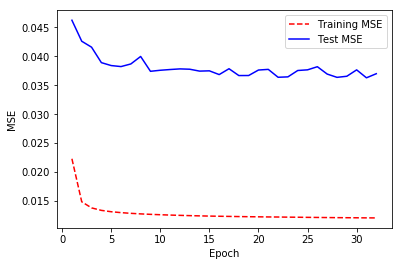

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig = plt.figure()
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

fig.savefig('patience_mse_vs_epoch_cnn_ae.png')



In [ ]:
# it still went through the whole 50 epochs

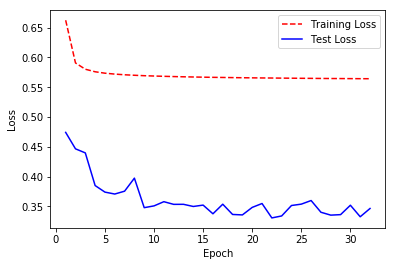

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig = plt.figure()
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

fig.savefig('patience_loss_vs_epoch_cnn_ae.png')

decoded_imgs.shape (57960, 28, 28, 1)


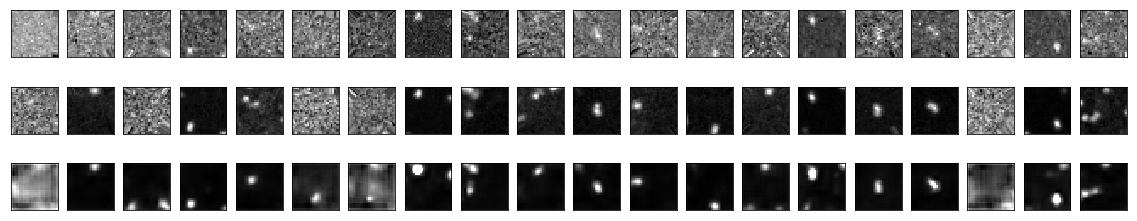

In [13]:
decoded_imgs = autoencoder.predict(bd_test)
print("decoded_imgs.shape",decoded_imgs.shape)

import matplotlib.pyplot as plt

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(bd_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(gd_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

fig.savefig('patience_PredVsGT')

Top row is input
<br>
Middle row is the good images (ground truth)
<br>
Last row is the prediction

In [20]:
gd_test_28x28 = gd_test.reshape((gd_test.shape[0],28,28))
decoded_imgs_patience_28x28 = decoded_imgs_patience.reshape((decoded_imgs_patience.shape[0],28,28))

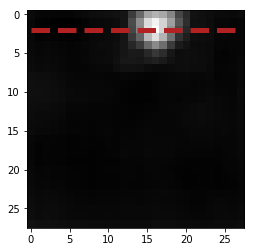

In [21]:
fig, ax = plt.subplots()
x=[2] * 28
y = range(28)
ax.imshow(decoded_imgs_patience_28x28[1])
ax.plot(y, x, '--', linewidth=5, color='firebrick')
fig.savefig('PATIENCE_row2_decoded.png')

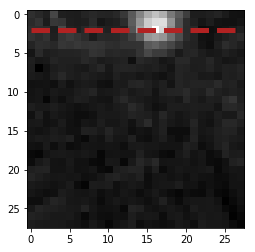

In [22]:
fig, ax = plt.subplots()
x=[2] * 28
y = range(28)
ax.imshow(gd_test_28x28[1])
ax.plot(y, x, '--', linewidth=5, color='firebrick')
fig.savefig('row2_gd_test.png')

In [23]:
int_list2=[]
for i in range(28):
    int_list2.append(decoded_imgs_patience_28x28[1][2,i])
    
int_list=[]
for i in range(28):
    int_list.append(gd_test_28x28[1][2,i])

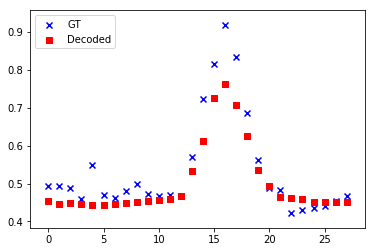

In [24]:

fig = plt.figure()
plt.scatter(range(28),int_list,c='b', marker='x', label='GT')
plt.scatter(range(28),int_list2, c='r', marker='s', label='Decoded')
plt.legend(loc='upper left')
plt.show()
fig.savefig('PATIENCE_intesity_plot_row3.png')

In [9]:
gd_test = bd_test.reshape((bd_test.shape[0],28*28))
decoded_imgs_patience = decoded_imgs_patience.reshape((decoded_imgs_patience.shape[0],28*28))
print('shape of gd_test'+ str(gd_test.shape))
print('shape of decoded_imgs'+ str(decoded_imgs_patience.shape))

shape of gd_test(57960, 784)
shape of decoded_imgs(57960, 784)


In [11]:
mse = np.mean(np.power(gd_test-decoded_imgs_patience, 2), axis=1)
print(len(mse))

57960


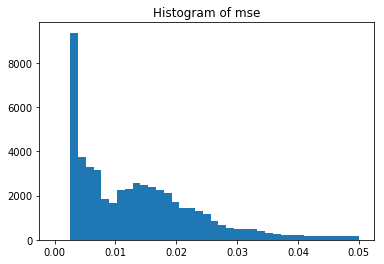

In [12]:
plt.hist(mse, bins=np.linspace(0.0,0.05,40))  # arguments are passed to np.histogram
plt.title("Histogram of mse")
plt.show()

## Eye test betweek the 50 epoch and the 22 epoch model

In [5]:
from keras.models import load_model

## Load best model the one using patience

##load the 50 epoch model
#load model
network_patience = load_model('best_model.h5')

decoded_imgs_patience = network_patience.predict(bd_test)
print("decoded_imgs_patience.shape  ",decoded_imgs_patience.shape)


decoded_imgs_patience.shape   (57960, 28, 28, 1)


In [10]:
network_50ep = load_model('ae_CNN_28.h5')
#decoded images 
decoded_imgs_50ep = network_50ep.predict(bd_test)
print("decoded_imgs_50ep.shape  ",decoded_imgs_50ep.shape)

decoded_imgs_50ep.shape   (57960, 28, 28, 1)


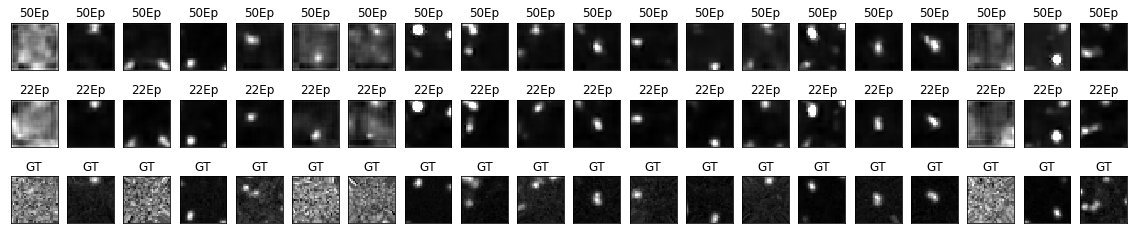

In [18]:
import matplotlib.pyplot as plt

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(decoded_imgs_50ep[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('50Ep')
    
        # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_patience[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('22Ep')
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(gd_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('GT')
plt.show()

In [ ]:
## Looks like the model reached with patience gives slightly better results as expected. 